##Setup & Imports

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


##Unzip Datasets

In [6]:
with zipfile.ZipFile("/content/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data/train")

In [7]:
with zipfile.ZipFile("/content/test.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data/test")

##Load Images & Labels

In [8]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for label in sorted(os.listdir(folder_path)):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (48, 48))
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_folder("/content/data/train/train")
X_test, y_test = load_images_from_folder("/content/data/test/test")

## Normalize and Reshape for CNN/ANN



In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique y_train labels:", np.unique(y_train))

X_train shape: (28709, 48, 48)
y_train shape: (28709,)
Unique y_train labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [10]:
import os

train_path = "/content/data/train"
for label in os.listdir(train_path):
    label_folder = os.path.join(train_path, label)
    if os.path.isdir(label_folder):
        print(f"Label: {label} | Images: {len(os.listdir(label_folder))}")

Label: __MACOSX | Images: 2
Label: train | Images: 7


In [11]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for label in sorted(os.listdir(folder_path)):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (48, 48))
                    images.append(img)
                    labels.append(str(label))
    return np.array(images), np.array(labels)

In [12]:
print("Sample y_train:", y_train[:10])
print("Label type:", type(y_train[0]))
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)


Sample y_train: ['angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry'
 'angry']
Label type: <class 'numpy.str_'>


In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train_dl = X_train.reshape(-1, 48, 48, 1)
X_test_dl = X_test.reshape(-1, 48, 48, 1)

y_train = y_train.astype(str)
y_test = y_test.astype(str)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

print("X_train_dl shape:", X_train_dl.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("Classes:", encoder.classes_)


X_train_dl shape: (28709, 48, 48, 1)
y_train_cat shape: (28709, 7)
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


##Sample Images from Dataset

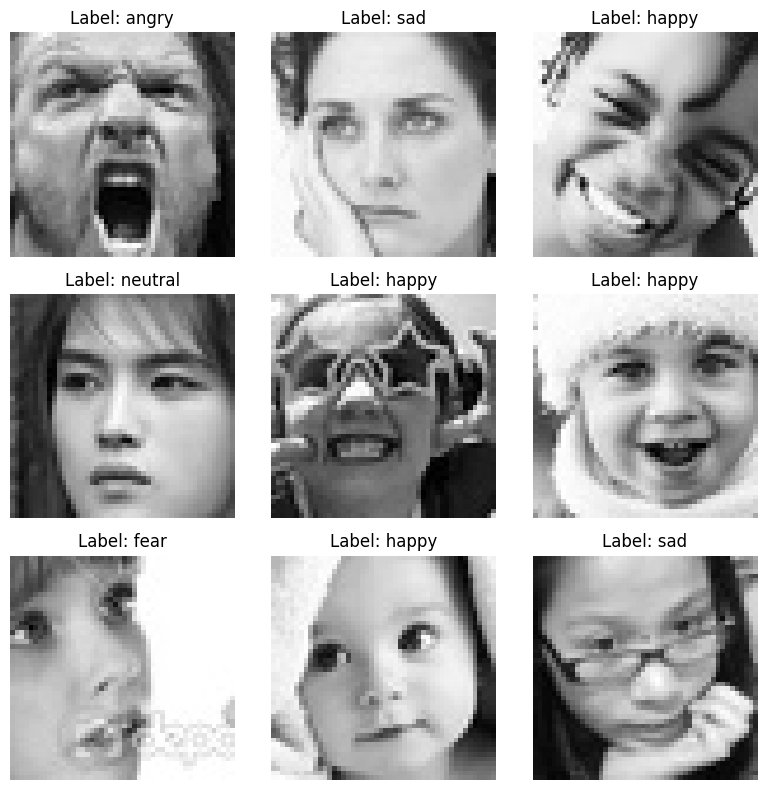

In [14]:
import matplotlib.pyplot as plt

def show_sample_images(images, labels, class_names, num_samples=9):
    plt.figure(figsize=(8, 8))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {class_names[labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(X_train, y_train_encoded, encoder.classes_)

##CNN Model

In [15]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_dl, y_train_cat, epochs=50, validation_data=(X_test_dl, y_test_cat))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2813 - loss: 1.7604 - val_accuracy: 0.4313 - val_loss: 1.4816
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4080 - loss: 1.5237 - val_accuracy: 0.4617 - val_loss: 1.4269
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4414 - loss: 1.4476 - val_accuracy: 0.4815 - val_loss: 1.3628
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4638 - loss: 1.3932 - val_accuracy: 0.4880 - val_loss: 1.3222
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4834 - loss: 1.3450 - val_accuracy: 0.5082 - val_loss: 1.2888
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4971 - loss: 1.3065 - val_accuracy: 0.5064 - val_loss: 1.2675
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5169 - loss: 1.2530 - val_accuracy: 0.5120 - val_loss: 1.2618
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5271 - loss: 1.2232 - val_accuracy: 0

##ANN Model

In [16]:
X_train_ann = X_train_dl.reshape(-1, 48*48)
X_test_ann = X_test_dl.reshape(-1, 48*48)

ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(48*48,)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

ann_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train_ann, y_train_cat, epochs=50, validation_data=(X_test_ann, y_test_cat))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2253 - loss: 1.9283 - val_accuracy: 0.2471 - val_loss: 1.8136
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2532 - loss: 1.8092 - val_accuracy: 0.2471 - val_loss: 1.8123
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2532 - loss: 1.8037 - val_accuracy: 0.2473 - val_loss: 1.7839
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2498 - loss: 1.7987 - val_accuracy: 0.2473 - val_loss: 1.7858
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2488 - loss: 1.7891 - val_accuracy: 0.2473 - val_loss: 1.7613
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2511 - loss: 1.7834 - val_accuracy: 0.2473 - val_loss: 1.7591
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2484 - loss: 1.7780 - val_accuracy: 0.2474 - val_loss: 1.7568
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2514 - loss: 1.7803 - val_accuracy: 0.

##HOG Feature Extraction for SVM & RF

In [17]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

##SVM Model

In [18]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_hog, y_train_encoded)
svm_preds = svm_model.predict(X_test_hog)

print("SVM Report:\n", classification_report(y_test_encoded, svm_preds))

SVM Report:
               precision    recall  f1-score   support

           0       0.43      0.36      0.39       958
           1       1.00      0.20      0.33       111
           2       0.45      0.30      0.36      1024
           3       0.63      0.80      0.71      1774
           4       0.48      0.54      0.51      1233
           5       0.41      0.45      0.43      1247
           6       0.73      0.61      0.67       831

    accuracy                           0.53      7178
   macro avg       0.59      0.47      0.48      7178
weighted avg       0.53      0.53      0.52      7178



##Random Forest Model

In [19]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_hog, y_train_encoded)
rf_preds = rf_model.predict(X_test_hog)

print("RF Report:\n", classification_report(y_test_encoded, rf_preds))

RF Report:
               precision    recall  f1-score   support

           0       0.42      0.22      0.29       958
           1       1.00      0.27      0.43       111
           2       0.41      0.24      0.30      1024
           3       0.47      0.84      0.61      1774
           4       0.39      0.45      0.42      1233
           5       0.34      0.26      0.29      1247
           6       0.78      0.48      0.60       831

    accuracy                           0.45      7178
   macro avg       0.54      0.39      0.42      7178
weighted avg       0.46      0.45      0.43      7178



## Precision, Recall, F1-Score, and Accuracy

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(y_true, y_pred, model_name="Model"):
    print(f"\n--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=encoder.classes_))

print_metrics(y_test_encoded, svm_preds, "SVM")
print_metrics(y_test_encoded, rf_preds, "Random Forest")


--- SVM ---
Accuracy: 0.5321816662022848
Precision: 0.5318283904991358
Recall: 0.5321816662022848
F1-score: 0.5222391336918968
Classification Report:
               precision    recall  f1-score   support

       angry       0.43      0.36      0.39       958
     disgust       1.00      0.20      0.33       111
        fear       0.45      0.30      0.36      1024
       happy       0.63      0.80      0.71      1774
     neutral       0.48      0.54      0.51      1233
         sad       0.41      0.45      0.43      1247
    surprise       0.73      0.61      0.67       831

    accuracy                           0.53      7178
   macro avg       0.59      0.47      0.48      7178
weighted avg       0.53      0.53      0.52      7178


--- Random Forest ---
Accuracy: 0.45305098913346337
Precision: 0.4620592151809581
Recall: 0.45305098913346337
F1-score: 0.42873237553244925
Classification Report:
               precision    recall  f1-score   support

       angry       0.42      0.

In [21]:
cnn_preds = np.argmax(cnn_model.predict(X_test_dl), axis=1)
ann_preds = np.argmax(ann_model.predict(X_test_ann), axis=1)

print_metrics(y_test_encoded, cnn_preds, "CNN")
print_metrics(y_test_encoded, ann_preds, "ANN")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- CNN ---
Accuracy: 0.5367790470883255
Precision: 0.5401582229411678
Recall: 0.5367790470883255
F1-score: 0.5368332290994918
Classification Report:
               precision    recall  f1-score   support

       angry       0.39      0.44      0.41       958
     disgust       0.79      0.38      0.51       111
        fear       0.39      0.37      0.38      1024
       happy       0.72      0.75      0.73      1774
     neutral       0.50      0.46      0.48      1233
         sad       0.40      0.42      0.41      1247
    surprise       0.75      0.71      0.73       831

    accuracy                           0.54      7178
   macro avg       0.56      0.50      0.52      7178
weighted avg       0.54      0.54      0.54      7178


--- ANN ---
Accuracy: 0.23989969350794094
Precision: 0.22322547817664865
Recall: 0.23989969350794094
F1-score: 0.10534981071582435
Classification Report:
              

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

##Confusion Matrix Plot

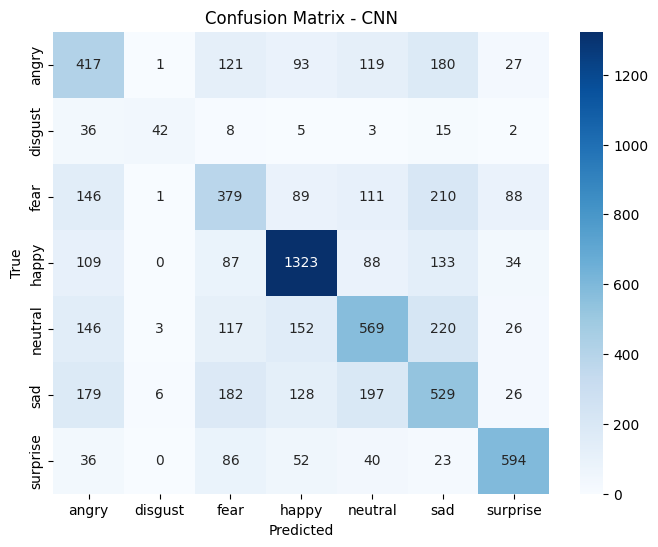

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

plot_confusion_matrix(y_test_encoded, cnn_preds, "CNN")

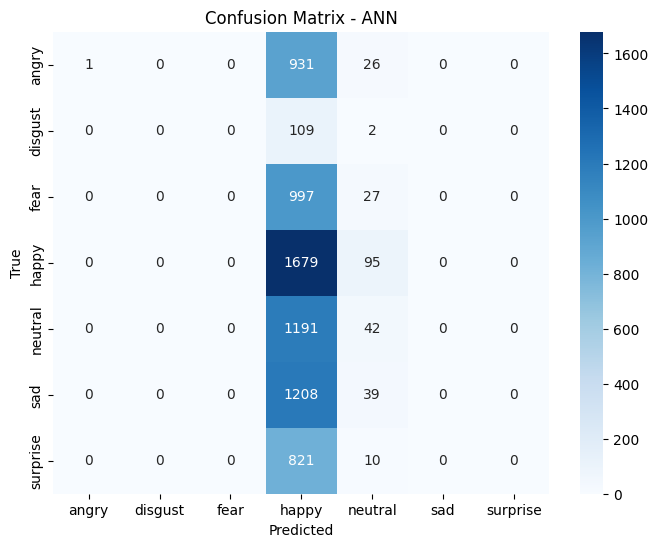

In [23]:
plot_confusion_matrix(y_test_encoded, ann_preds, "ANN")

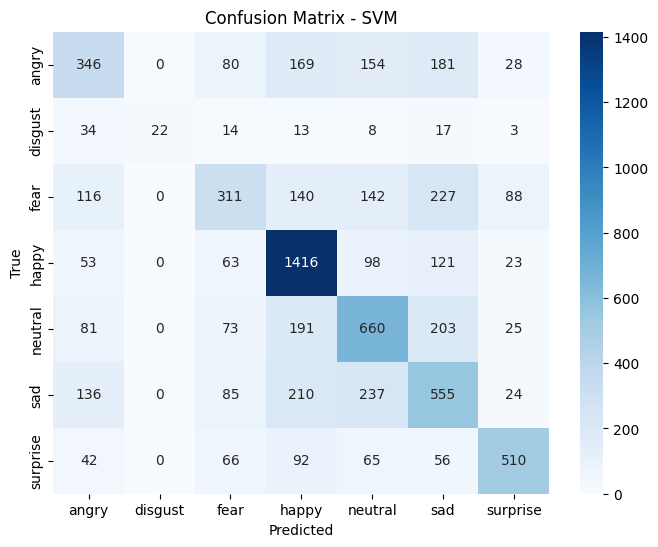

In [24]:
plot_confusion_matrix(y_test_encoded, svm_preds, "SVM")

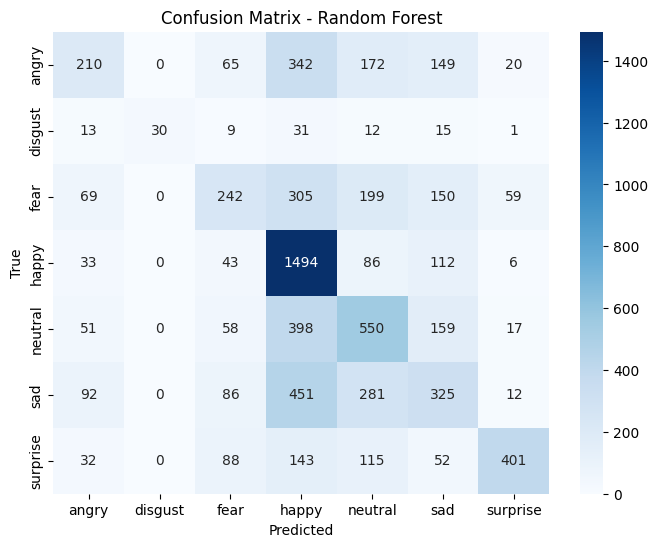

In [25]:
plot_confusion_matrix(y_test_encoded, rf_preds, "Random Forest")

##Define Metric Calculation Function

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }

###Get Predictions for Each Model

In [27]:
cnn_preds = np.argmax(cnn_model.predict(X_test_dl), axis=1)
ann_preds = np.argmax(ann_model.predict(X_test_ann), axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


###Calculate All Metrics

In [28]:
metrics_dict = {
    'CNN': calculate_metrics(y_test_encoded, cnn_preds),
    'ANN': calculate_metrics(y_test_encoded, ann_preds),
    'SVM': calculate_metrics(y_test_encoded, svm_preds),
    'RF': calculate_metrics(y_test_encoded, rf_preds)
}

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Plot All Metrics in One Chart

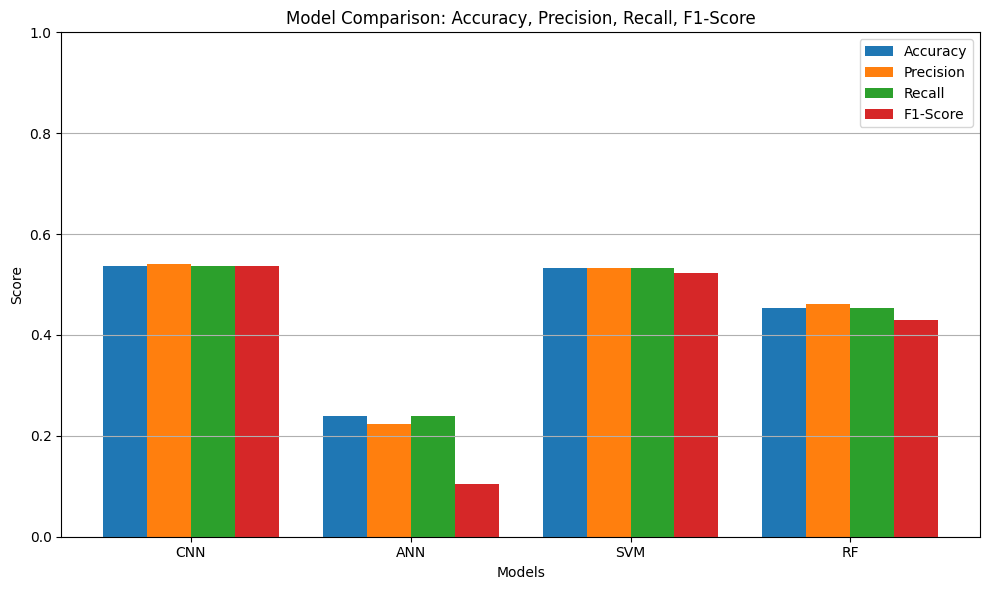

In [29]:
import matplotlib.pyplot as plt

def plot_model_comparison(metrics_dict):
    labels = list(metrics_dict.keys())
    accuracy = [metrics_dict[m]['accuracy'] for m in labels]
    precision = [metrics_dict[m]['precision'] for m in labels]
    recall = [metrics_dict[m]['recall'] for m in labels]
    f1 = [metrics_dict[m]['f1'] for m in labels]

    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
    plt.bar(x - 0.5*width, precision, width, label='Precision')
    plt.bar(x + 0.5*width, recall, width, label='Recall')
    plt.bar(x + 1.5*width, f1, width, label='F1-Score')

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Comparison: Accuracy, Precision, Recall, F1-Score')
    plt.xticks(x, labels)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_model_comparison(metrics_dict)
